In [24]:
import shutil
import wget
import sys, getopt
import os
from subprocess import Popen, PIPE, check_output
import numpy as np
import cv2

MIDRISE = 'midrise'
MIDTHREAD = 'midthread'
DEADZONE = 'deadzone'
QUANTIZIERS = [MIDRISE, MIDTHREAD, DEADZONE]
N_ITERATIONS = 0
VIDEOFILE_NAME = 'test_video'
VIDEOFILE_URL = ''
DEFAULT_DIR = '/tmp/mcdwt/'
TMP_DIR = ''
LOOP_STEP = 1
POWER_OF_TWO = True


def do_cleanup(tmp_dir):
   '''
   Clean working directory
   Parameters
   ----------
   tmp_dir - string dir location

   Returns
   -------
   none
   '''
   print('Limpiando directorio de trabajo: %s' % tmp_dir)
   if (os.path.exists(tmp_dir)):
      try:
         shutil.rmtree(tmp_dir)
      except:
         print('Error while deleting directory')
   os.makedirs(tmp_dir, exist_ok=True)


def download_file_to_folder(videofile_url, videofile_name):
   '''
   Download video to location and assign name to videofile
   Parameters
   ----------
   videofile_url - video url
   videofile_name - location and filename for the video

   Returns
   -------

   '''
   print('Descargando archivo: \'%s\' a \'%s\'' % (videofile_url, videofile_name))
   res = wget.download(videofile_url, out=videofile_name)
   print('\n')
   return res


def extract_frames(tmp_dir, gop, videofile):
   '''
   Extract frames using ffmpeg and rename generated images from 001..999 to 000..999
   Files will be placed in directory TMP_DIR/GOP
   Parameters
   ----------
   TMP_DIR - DIRECTORY FOR THE IMAGES
   GOP - GROUP OF IMAGES

   Returns
   -------
   base directory with original images
   '''
   print('Extrayendo %s imagenes a %s' % (str(gop), tmp_dir))
   # ffmpeg -hide_banner -loglevel info -i $file -vframes 9 $folder%03d.png &
   base_dir = tmp_dir + str(gop) + os.sep
   pattern_dir = base_dir + 'original' + os.sep
   os.makedirs(pattern_dir, exist_ok=True)
   pattern = pattern_dir + '%3d.png'
   args = ['ffmpeg', '-hide_banner', '-loglevel', 'info', '-i', videofile, '-vframes', str(gop), pattern]
   execute_command(args)

   # fix frame numbering
   for i in range(1, gop):
      from_file = pattern_dir + str(i).zfill(3) + '.png'
      to_file = pattern_dir + str(i - 1).zfill(3) + '.png'
      shutil.copy(from_file, to_file)

   # remove last file
   rmfile = pattern_dir + str(gop).zfill(3) + '.png'
   os.remove(rmfile)

   # copy originals to res directory where algorythm will be applied
   res_dir = base_dir + 'res' + os.sep
   shutil.copytree(pattern_dir, res_dir)
   return base_dir


def execute_mdwt(image_directory, gop, inverse=False):
   '''
   calls mcdwt algorythm
   Parameters
   ----------
   image_directory - location of the images to process
   gop - group of pictures (number of images to process)

   Returns
   -------
   POPEN object
   '''
   print('Ejecutando MDWT.py para %s imagenes inverse: %s' %(str(gop), str(inverse)))
   # MDWT.py -N $num_imgs -p /tmp/
   args = ['python3', '-O', 'MDWT.py', '-N', str(gop), '-p', image_directory]
   if inverse == True: args.append('-b')
   return execute_command(args)


def execute_mcdwt(image_directory, gop, n_iteration, predictor=1, inverse=False):
   '''

   Parameters
   ----------
   image_directory - location of the images to process
   gop - group of pictures (number of images to process)
   n_iteration - number of iterations
   predictor - predictor value

   Returns
   -------
   POPEN object
   '''
   print('Ejecutando MCDWT.py para imagenes %s, predictor %s, iteraciones %s inverse: %s' %(str(gop), str(predictor),
                                                                                            str(n_iteration), str(inverse)))
   # !python3 -O MCDWT.py -N $num_imgs -P $predictor -p /tmp/ -T $iterations
   args = ['python3', '-O', 'MCDWT.py', '-N', str(gop - 1), '-P', str(predictor), '-p', image_directory, '-T',
           str(n_iteration)]
   if inverse == True: args.append('-b')
   return execute_command(args)


def execute_command(args, cmd=None, shell=False):
   '''
   executes command in shell
   Parameters
   ----------
   args - command and arguments
   cmd - required for rm command
   shell - popen shell parameter

   Returns
   -------

   '''
   if cmd is None:
      p = Popen(args, stdin=PIPE, stdout=PIPE, stderr=PIPE, shell=shell)
   else:
      p = Popen("%s %s" % (cmd, args), shell=True, stdin=PIPE, stdout=PIPE, stderr=PIPE)
   p.wait()
   return p


def get_dirsize(dir_path, suffix="B"):
   res = int(check_output(['du', '-sb', dir_path]).split()[0].decode('utf-8'))
   print('sizeof: %s: %s' % (dir_path, str(res)))
   return get_size_format(res, suffix=suffix)


def get_size_format(b, suffix="B"):
   '''
   Transform value in bytes (integer) into KB,MB,GB,TB
   Parameters
   ----------
   b - integer value in bytes
   suffix - KB,MB,GB,TB

   Returns
   -------
   integer value in B,KB,MB,GB,TB
   '''
   if isinstance(b, int):
      if suffix == "B":
         pass
      elif suffix == "KB":
         b = int(b / 1024)
      elif suffix == "KB":
         b = int(b / 1024 ** 2)
      elif suffix == "KB":
         b = int(b / 1024 ** 3)
      elif suffix == "KB":
         b = int(b / 1024 ** 4)
      else:
         print('WRONG FORMAT: \'>%s<\', RETURNING KB' % suffix)
   else:
      raise ValueError("var: %s of type: \'%s\' is not an int" % (str(b), type(b)))
   return b



def prepare_current_iteration_directory(tmp_dir, curr_gop, gop):
   '''
   Copy all the images to the directory for the current iteration and remove
   pictures that won't be processed for the current gop number
   Parameters
   ----------
   tmp_dir - working directory
   curr_gop - current gop number
   gop - total gop number

   Returns
   -------
   destination directory (string)
   '''
   srt_dir = tmp_dir + str(gop) + os.sep
   dst_dir = tmp_dir + str(curr_gop) + os.sep
   print('Copiando %s imagenes al directorio: %s' %(str(curr_gop), dst_dir))
   #os.makedirs(tmp_dir, exist_ok=True)
   shutil.copytree(srt_dir, dst_dir)
   #remove extra images
   for i in range(curr_gop, gop):
      rm_file_original = dst_dir + 'original' + os.sep + str(i).zfill(3) + '.png'
      rm_file_res = dst_dir + 'res' + os.sep + str(i).zfill(3) + '.png'
      os.remove(rm_file_original)
      os.remove(rm_file_res)
   return dst_dir


def quantize_image_function(input_path, output_path, q_step, quantize_algorithm):
   # print('--------------------------------------------------------------------------')
   # print('----->%s<------' %input_path)
   # print('----->%s<------' % output_path)
   # print('----->%s<------' % q_step)
   # print('----->%s<------' %quantize_algorithm)
   # Read image
   image = cv2.imread(input_path, -1)
   # Transformation needed because Vicente said in forum
   tmp = image.astype(np.float32)
   tmp -= 32768

   if quantize_algorithm == MIDRISE:
      image = np.floor(tmp / q_step).astype(np.int16) * q_step + (q_step / 2)
   elif quantize_algorithm == MIDTHREAD:
      image = np.round(tmp / q_step).astype(np.int16) * q_step
   elif quantize_algorithm == DEADZONE:
      image = (tmp / q_step).astype(np.int16).astype(np.int)
   else:
      image = (tmp / q_step).astype(np.int16) * q_step  # Vicente's quantizer.py algorithm

   # Transformation needed because Vicente said in forum
   tmp = image.astype(np.float32)
   tmp += 32768
   image = tmp.astype(np.uint16)

   # Write image quantizied
   cv2.imwrite(output_path, image)

def prepare_quantization_directories(tmp_dir, q_step=32):
   '''
   Copy images from mcdwt result algorithm into 3 directories for quantifier evaluation
   Parameters
   ----------
   dir - string working directory
   dir_arr - array of dir_names to copy res directory
   Returns
   -------
   array destination directories full paths
   '''
   print('PREPARE DIRECTORIES FOR QUANTIZATION')
   global DEFAULT_DIR
   if isinstance(tmp_dir, str):
      if (tmp_dir == ''): tmp_dir = DEFAULT_DIR
      if (not tmp_dir.endswith(os.sep)):
         tmp_dir += os.sep
      if len(QUANTIZIERS) > 0:
         directories = [name for name in os.listdir(tmp_dir) if os.path.isdir(os.path.join(tmp_dir, name))]
         res_dirs = []
         for dir in directories:
            curr_path = tmp_dir + dir + os.sep
            for d in QUANTIZIERS:
               src_dir = curr_path + 'res' + os.sep
               dst_dir = curr_path + d + os.sep
               #remove dst_dir if exists
               cmd = 'rm'
               args = '-rf %s' % dst_dir
               execute_command(args, cmd=cmd, shell=True)

               os.makedirs(dst_dir, exist_ok=True)
               res_dirs.append(dst_dir)
               print('creating directory: %s' %dst_dir)

         return res_dirs
      else:
         raise Exception('dir_arr cannot be empty')
   else:
      raise Exception('tmp_dir must be a string')

def mse(path_A, path_B):
   '''
   mean( (A-B)**2 )
   Parameters
   ----------
   path_A - A image path
   path_B - B image path

   Returns
   -------
   mse value
   '''
   A = cv2.imread(path_A, -1)
   B = cv2.imread(path_B, -1)
   mse = np.mean((A - B) ** 2)
   return mse


def func_qstep(qstep):
   if POWER_OF_TWO == True:
      qstep = int(pow(2, qstep))
   return qstep

def quantisize_images(tmp_dir, videofile_url, n_iterations, predictor=2, suffix='B',q_step=None, min_qstep=1, max_qstep=6, normalize=False):
   global DEFAULT_DIR
   if min_qstep > max_qstep: min_qstep= max_qstep
   if max_qstep < min_qstep: max_qstep = min_qstep
   if q_step is not None: min_qstep = max_qstep = q_step
   if (tmp_dir == ''): tmp_dir = DEFAULT_DIR
   if not tmp_dir.endswith(os.sep): tmp_dir += os.sep
   # execute mdwt and mcdwt
   original, compressed = compress_mcdwt_once(tmp_dir, videofile_url, n_iterations, predictor=predictor, suffix=suffix)

   # prepare directories
   # dir_paths = prepare_quantization_directories(tmp_dir, q_step=q_step)
   # print('dir_paths: %s' %str(dir_paths))
   curr_dir = tmp_dir + str(pow(2, n_iterations)) + os.sep
   # get res directory path
   res_dir = curr_dir + 'res' + os.sep
   print('list dir: %s' %res_dir)
   # read image names from res directory
   img_arr = [name for name in os.listdir(res_dir) if (os.path.isfile(os.path.join(res_dir, name)) and name.endswith('.png'))]
   print('--------------------------------------------------------------------------------------------')
   print('cuantificando imagenes arrlength: %s' %(str(len(img_arr))))
   print('--------------------------------------------------------------------------------------------')
   # quantify images applying q_step 1..max_qstep
   for q_func in QUANTIZIERS:
      print('cuantificandor: %s ' % (q_func))
      for img_name in img_arr:
         src_image = res_dir + img_name
         #for qstep in range(min_qstep, max_qstep + 1):
         print('procesando imagen: %s' %src_image)
         for qstep in range(min_qstep, max_qstep + 1, LOOP_STEP):
            qstep = func_qstep(qstep)

            dst_dir = curr_dir + q_func + os.sep + str(qstep).zfill(2) + os.sep + 'res' + os.sep
            os.makedirs(dst_dir, exist_ok=True)
            dst_image = dst_dir + img_name
            quantize_image_function(src_image, dst_image, qstep, q_func)
   print('--------------------------------------------------------------------------------------------')
   print('descopmrimiendo imagenes cuantificadas')
   print('--------------------------------------------------------------------------------------------')
   mse_values = {}
   mse_values[DEADZONE] = {}
   mse_values[MIDTHREAD] = {}
   mse_values[MIDRISE] = {}
   for q_func in QUANTIZIERS:
      #for qstep in range(min_qstep, max_qstep + 1):
      for qstep in range(min_qstep, max_qstep + 1, LOOP_STEP):
         qstep = func_qstep(qstep)
         mse_values[q_func][str(qstep)] = []

         print('cuantificandor: %s, qstep: %s ' % (q_func, qstep))
         q_dir = curr_dir + q_func + os.sep + str(qstep).zfill(2) + os.sep
         qres_dir = q_dir + 'res' + os.sep
         qdst_dir = q_dir + 'decompressed' + os.sep

         print('copiando imagenes antes de descomprimir: %s -> %s' %(qres_dir,qdst_dir))
         shutil.copytree(qres_dir, qdst_dir)

         #python3 -O MCDWT.py -P $predictor -p /tmp/ -b
         execute_mcdwt(qdst_dir, pow(2, n_iterations), n_iterations, predictor=predictor, inverse=True)
         #python3 -O MDWT.py -p /tmp/ -b
         execute_mdwt(qdst_dir, pow(2, n_iterations), inverse=True)
         print('eliminando subbandas (rm -rf ?????.png)')
         cmd = 'rm'
         args = '-rf %s?????.png' %qdst_dir
         execute_command(args, cmd=cmd, shell=True)

         print('--------------------------------------------------------------------------------------------')
         print('calculando mse para q_func: %s, qstep: %s' %(q_func, q_step))
         img_arr = [name for name in os.listdir(qdst_dir) if (os.path.isfile(os.path.join(qdst_dir, name)) and name.endswith('.png'))]
         print('directorio: %s' %qdst_dir)

         for img_name in img_arr:
            img_A = curr_dir + 'original' + os.sep + img_name
            img_B = qdst_dir + img_name
            mse_val = mse(img_A, img_B)
            mse_values[q_func][str(qstep)].append(mse_val)

         print(str(mse_values[q_func][str(qstep)]))
         print(str(np.mean(mse_values[q_func][str(qstep)])))

         if normalize == True:
            print('--------------------------------------------------------------------------------------------')
            print('normalizando imagenes cuantificadas')
            print('--------------------------------------------------------------------------------------------')
            img_arr = [name for name in os.listdir(qdst_dir) if (os.path.isfile(os.path.join(qdst_dir, name)) and len(name)<8)]
            for img in img_arr:
               img = qdst_dir + img
               args = ['convert', '-normalize', img, img]
               execute_command(args)
   return mse_values

def compress_mcdwt_once(tmp_dir, videofile_url, n_iterations, predictor=1, suffix='B'):
   global DEFAULT_DIR
   if (tmp_dir == ''): tmp_dir = DEFAULT_DIR
   y_arr = []
   y1_arr = []

   if (n_iterations == 0):
      raise Exception("El número de iteraciones no puede ser igual a 0")
   # cleanup
   do_cleanup(tmp_dir)
   # download file
   videofile = tmp_dir + VIDEOFILE_NAME
   download_file_to_folder(videofile_url, videofile)

   # extract frames ONCE to folder
   all_images_dir = extract_frames(tmp_dir, pow(2, n_iterations), videofile)

   curr_gop = pow(2, n_iterations)
   curr_dir = all_images_dir
   res_dir = curr_dir + 'res' + os.sep
   # execute MDWT algorythm
   execute_mdwt(res_dir, curr_gop)
   # execute MCDWT algorythm
   execute_mcdwt(res_dir, curr_gop, n_iterations, predictor)

   # remove original files from compressed directory
   rm_pattern = res_dir + '???.png'
   cmd = 'rm'
   args = '-rf %s' % rm_pattern
   execute_command(args, cmd=cmd, shell=True)

   # calculate size of directories
   print('Calculando tamaño de directorios')
   original_dir = curr_dir + 'original' + os.sep
   y = get_dirsize(original_dir, suffix=suffix)
   y1 = get_dirsize(res_dir, suffix=suffix)
   y_arr.append(y)
   y1_arr.append(y1)
   return y_arr, y1_arr

def compress_mcdwt_iterative(tmp_dir, videofile_url, n_iterations, predictor=1, suffix='B'):
   '''
   Main function, executes the process of running all the steps to compress images
   and calculate the size of them before and after compression
   Parameters
   ----------
   tmp_dir - working directory to extract images from the video and do processing
   videofile_url - url of the video
   n_iterations - number of iterations for mcdwt
   predictor - predictor value
   suffix - suffix for directory size (default=B,KB,MB,GB)

   Returns
   -------
   Two arrays: original_sizes, compressed sizes
   '''
   global DEFAULT_DIR
   if (tmp_dir == ''): tmp_dir = DEFAULT_DIR
   y_arr = []
   y1_arr = []

   if (n_iterations == 0):
      raise Exception("El número de iteraciones no puede ser igual a 0")
   # cleanup
   do_cleanup(tmp_dir)
   # download file
   videofile = tmp_dir + VIDEOFILE_NAME
   download_file_to_folder(videofile_url, videofile)

   # extract frames ONCE to folder
   all_images_dir = extract_frames(tmp_dir, pow(2, n_iterations), videofile)

   for curr_iteration in range(1, n_iterations + 1):
      curr_gop = pow(2, curr_iteration)
      #prepare directory
      if curr_gop != pow(2, n_iterations):
         curr_dir = prepare_current_iteration_directory(tmp_dir, curr_gop, pow(2, n_iterations))
      else:
         curr_dir = all_images_dir

      # execute MDWT algorythm
      res_dir = curr_dir + 'res' + os.sep
      execute_mdwt(res_dir, curr_gop)
      # execute MCDWT algorythm
      execute_mcdwt(res_dir, curr_gop, curr_iteration, predictor)

      # remove original files from compressed directory
      rm_pattern = res_dir + '???.png'
      cmd = 'rm'
      args = '-rf %s' % rm_pattern
      execute_command(args, cmd=cmd, shell=True)

      # calculate size of directories
      print('Calculando tamaño de directorios')
      original_dir = curr_dir + 'original' + os.sep
      y = get_dirsize(original_dir, suffix=suffix)
      y1 = get_dirsize(res_dir, suffix=suffix)
      y_arr.append(y)
      y1_arr.append(y1)
   return y_arr, y1_arr


# CONFIGURE PARAMETERS

In [26]:
videofile_url = 'https://media.xiph.org/video/derf/y4m/city_cif.y4m'
dir1 = '/tmp/test/'
n_iterations=3
q_step = None
min_qstep = 1
max_qstep = 6
LOOP_STEP = 1
#if power_of_two is set, loop will iterate 2^q_step
POWER_OF_TWO = False
if POWER_OF_TWO == True and max_qstep > 9: max_qstep = 9
normalize=True #nombalize image after calculating size
mse_values = quantisize_images(dir1, videofile_url, n_iterations,normalize=normalize, q_step=q_step, min_qstep=min_qstep, max_qstep=max_qstep)

Limpiando directorio de trabajo: /tmp/test/
Descargando archivo: 'https://media.xiph.org/video/derf/y4m/city_cif.y4m' a '/tmp/test/test_video'


Extrayendo 8 imagenes a /tmp/test/
Ejecutando MDWT.py para 8 imagenes inverse: False
Ejecutando MCDWT.py para imagenes 8, predictor 2, iteraciones 3 inverse: False
Calculando tamaño de directorios
sizeof: /tmp/test/8/original/: 1781701
sizeof: /tmp/test/8/res/: 2512785
list dir: /tmp/test/8/res/
--------------------------------------------------------------------------------------------
cuantificando imagenes arrlength: 32
--------------------------------------------------------------------------------------------
cuantificandor: midrise 
procesando imagen: /tmp/test/8/res/LL007.png
procesando imagen: /tmp/test/8/res/HL003.png
procesando imagen: /tmp/test/8/res/LL001.png
procesando imagen: /tmp/test/8/res/HH007.png
procesando imagen: /tmp/test/8/res/HL004.png
procesando imagen: /tmp/test/8/res/LH001.png
procesando imagen: /tmp/test/8/res/HL001

Ejecutando MDWT.py para 8 imagenes inverse: True
eliminando subbandas (rm -rf ?????.png)
--------------------------------------------------------------------------------------------
calculando mse para q_func: midrise, qstep: None
directorio: /tmp/test/8/midrise/04/decompressed/
[4.470183606902357, 4.496498184974747, 3.159794560185185, 3.1373697916666665, 4.59235585016835, 3.125161116372054, 3.125161116372054, 4.598514441287879]
3.8381298334911618
--------------------------------------------------------------------------------------------
normalizando imagenes cuantificadas
--------------------------------------------------------------------------------------------
cuantificandor: midrise, qstep: 5 
copiando imagenes antes de descomprimir: /tmp/test/8/midrise/05/res/ -> /tmp/test/8/midrise/05/decompressed/
Ejecutando MCDWT.py para imagenes 8, predictor 2, iteraciones 3 inverse: True
Ejecutando MDWT.py para 8 imagenes inverse: True
eliminando subbandas (rm -rf ?????.png)
---------------

eliminando subbandas (rm -rf ?????.png)
--------------------------------------------------------------------------------------------
calculando mse para q_func: deadzone, qstep: None
directorio: /tmp/test/8/deadzone/01/decompressed/
[1.9968237058080809, 2.1182331123737375, 0.4506720854377104, 0.448666351010101, 2.0007891414141414, 0.44953769465488214, 0.44953769465488214, 2.128465646043771]
1.2553406789246633
--------------------------------------------------------------------------------------------
normalizando imagenes cuantificadas
--------------------------------------------------------------------------------------------
cuantificandor: deadzone, qstep: 2 
copiando imagenes antes de descomprimir: /tmp/test/8/deadzone/02/res/ -> /tmp/test/8/deadzone/02/decompressed/
Ejecutando MCDWT.py para imagenes 8, predictor 2, iteraciones 3 inverse: True
Ejecutando MDWT.py para 8 imagenes inverse: True
eliminando subbandas (rm -rf ?????.png)
---------------------------------------------------

In [27]:
import json
print (json.dumps(mse_values, sort_keys=True, indent=4))


{
    "deadzone": {
        "1": [
            1.9968237058080809,
            2.1182331123737375,
            0.4506720854377104,
            0.448666351010101,
            2.0007891414141414,
            0.44953769465488214,
            0.44953769465488214,
            2.128465646043771
        ],
        "2": [
            3546.097511574074,
            3543.3977009680134,
            3556.8316827125423,
            3541.874763257576,
            3538.089432738847,
            3538.6659367108587,
            3538.6659367108587,
            3551.475674715909
        ],
        "3": [
            6290.8154296875,
            6286.121080597643,
            6310.12117924032,
            6283.688282565236,
            6276.642821443603,
            6277.762922190656,
            6277.762922190656,
            6301.1784906355215
        ],
        "4": [
            7956.252045191498,
            7950.494499026726,
            7980.605968539562,
            7947.521606034301,
            

In [28]:
mse_dz = []#deadzone
mse_mr = []#midrise
mse_mt = []#midthread
# x - q values
x = []
it = 0
for i in range(min_qstep, max_qstep + 1, LOOP_STEP):
    x.append(i)
    mse_dz.append(np.mean(mse_values['deadzone'][str(func_qstep(i))]))
    mse_mr.append(np.mean(mse_values['midrise'][str(func_qstep(i))]))
    mse_mt.append(np.mean(mse_values['midthread'][str(func_qstep(i))]))
    it+=1

In [29]:
videofile_url = 'https://media.xiph.org/video/derf/y4m/football_422_ntsc.y4m'
mse_values1 = quantisize_images(dir1, videofile_url, n_iterations, q_step=q_step, min_qstep=min_qstep, max_qstep=max_qstep, normalize=normalize)

Limpiando directorio de trabajo: /tmp/test/
Descargando archivo: 'https://media.xiph.org/video/derf/y4m/football_422_ntsc.y4m' a '/tmp/test/test_video'


Extrayendo 8 imagenes a /tmp/test/
Ejecutando MDWT.py para 8 imagenes inverse: False
Ejecutando MCDWT.py para imagenes 8, predictor 2, iteraciones 3 inverse: False
Calculando tamaño de directorios
sizeof: /tmp/test/8/original/: 6770675
sizeof: /tmp/test/8/res/: 8025510
list dir: /tmp/test/8/res/
--------------------------------------------------------------------------------------------
cuantificando imagenes arrlength: 32
--------------------------------------------------------------------------------------------
cuantificandor: midrise 
procesando imagen: /tmp/test/8/res/LL007.png
procesando imagen: /tmp/test/8/res/HL003.png
procesando imagen: /tmp/test/8/res/LL001.png
procesando imagen: /tmp/test/8/res/HH007.png
procesando imagen: /tmp/test/8/res/HL004.png
procesando imagen: /tmp/test/8/res/LH001.png
procesando imagen: /tmp/test/8/

Ejecutando MDWT.py para 8 imagenes inverse: True
eliminando subbandas (rm -rf ?????.png)
--------------------------------------------------------------------------------------------
calculando mse para q_func: midrise, qstep: None
directorio: /tmp/test/8/midrise/04/decompressed/
[4.185165180612711, 4.238730757506477, 4.008292371589697, 2.6643042219173907, 4.074467497332724, 2.7477194787379973, 2.7477194787379973, 4.668980528882792]
3.6669224394147233
--------------------------------------------------------------------------------------------
normalizando imagenes cuantificadas
--------------------------------------------------------------------------------------------
cuantificandor: midrise, qstep: 5 
copiando imagenes antes de descomprimir: /tmp/test/8/midrise/05/res/ -> /tmp/test/8/midrise/05/decompressed/
Ejecutando MCDWT.py para imagenes 8, predictor 2, iteraciones 3 inverse: True
Ejecutando MDWT.py para 8 imagenes inverse: True
eliminando subbandas (rm -rf ?????.png)
------------

[1.9914590001524157, 2.549677069044353, 0.4522119341563786, 0.44863206828227403, 1.9895118884316416, 0.44620579942082, 0.44620579942082, 2.29887021795458]
1.3278467221079104
--------------------------------------------------------------------------------------------
normalizando imagenes cuantificadas
--------------------------------------------------------------------------------------------
cuantificandor: deadzone, qstep: 2 
copiando imagenes antes de descomprimir: /tmp/test/8/deadzone/02/res/ -> /tmp/test/8/deadzone/02/decompressed/
Ejecutando MCDWT.py para imagenes 8, predictor 2, iteraciones 3 inverse: True
Ejecutando MDWT.py para 8 imagenes inverse: True
eliminando subbandas (rm -rf ?????.png)
--------------------------------------------------------------------------------------------
calculando mse para q_func: deadzone, qstep: None
directorio: /tmp/test/8/deadzone/02/decompressed/
[3053.823712086572, 3067.50734739369, 3026.4293028882794, 3090.435749123609, 3108.636381649139, 3

In [30]:
mse_dz1 = []#deadzone
mse_mr1 = []#midrise
mse_mt1 = []#midthread
# x - q values
x = []
it = 0
for i in range(min_qstep, max_qstep + 1, LOOP_STEP):
    x.append(i)
    mse_dz1.append(np.mean(mse_values1['deadzone'][str(func_qstep(i))]))
    mse_mr1.append(np.mean(mse_values1['midrise'][str(func_qstep(i))]))
    mse_mt1.append(np.mean(mse_values1['midthread'][str(func_qstep(i))]))
    it+=1

In [31]:
videofile_url = 'https://media.xiph.org/video/derf/y4m/bus_cif.y4m'
mse_values2 = quantisize_images(dir1, videofile_url, n_iterations, q_step=q_step, min_qstep=min_qstep, max_qstep=max_qstep, normalize=normalize)

Limpiando directorio de trabajo: /tmp/test/
Descargando archivo: 'https://media.xiph.org/video/derf/y4m/bus_cif.y4m' a '/tmp/test/test_video'


Extrayendo 8 imagenes a /tmp/test/
Ejecutando MDWT.py para 8 imagenes inverse: False
Ejecutando MCDWT.py para imagenes 8, predictor 2, iteraciones 3 inverse: False
Calculando tamaño de directorios
sizeof: /tmp/test/8/original/: 1800465
sizeof: /tmp/test/8/res/: 2460749
list dir: /tmp/test/8/res/
--------------------------------------------------------------------------------------------
cuantificando imagenes arrlength: 32
--------------------------------------------------------------------------------------------
cuantificandor: midrise 
procesando imagen: /tmp/test/8/res/LL007.png
procesando imagen: /tmp/test/8/res/HL003.png
procesando imagen: /tmp/test/8/res/LL001.png
procesando imagen: /tmp/test/8/res/HH007.png
procesando imagen: /tmp/test/8/res/HL004.png
procesando imagen: /tmp/test/8/res/LH001.png
procesando imagen: /tmp/test/8/res/HL001.

Ejecutando MDWT.py para 8 imagenes inverse: True
eliminando subbandas (rm -rf ?????.png)
--------------------------------------------------------------------------------------------
calculando mse para q_func: midrise, qstep: None
directorio: /tmp/test/8/midrise/04/decompressed/
[4.666199757996633, 4.756990477693603, 3.316199100378788, 3.3466205018939394, 4.596561316287879, 3.3204867687289563, 3.3204867687289563, 4.731359822180135]
4.006863064236111
--------------------------------------------------------------------------------------------
normalizando imagenes cuantificadas
--------------------------------------------------------------------------------------------
cuantificandor: midrise, qstep: 5 
copiando imagenes antes de descomprimir: /tmp/test/8/midrise/05/res/ -> /tmp/test/8/midrise/05/decompressed/
Ejecutando MCDWT.py para imagenes 8, predictor 2, iteraciones 3 inverse: True
Ejecutando MDWT.py para 8 imagenes inverse: True
eliminando subbandas (rm -rf ?????.png)
-------------

eliminando subbandas (rm -rf ?????.png)
--------------------------------------------------------------------------------------------
calculando mse para q_func: deadzone, qstep: None
directorio: /tmp/test/8/deadzone/01/decompressed/
[1.993364635942761, 2.284659748526936, 0.44923847853535354, 0.4486696390993266, 1.9935224642255893, 0.44911353114478114, 0.44911353114478114, 2.2771530408249157]
1.2931043836805556
--------------------------------------------------------------------------------------------
normalizando imagenes cuantificadas
--------------------------------------------------------------------------------------------
cuantificandor: deadzone, qstep: 2 
copiando imagenes antes de descomprimir: /tmp/test/8/deadzone/02/res/ -> /tmp/test/8/deadzone/02/decompressed/
Ejecutando MCDWT.py para imagenes 8, predictor 2, iteraciones 3 inverse: True
Ejecutando MDWT.py para 8 imagenes inverse: True
eliminando subbandas (rm -rf ?????.png)
--------------------------------------------------

In [32]:
mse_dz2 = []#deadzone
mse_mr2 = []#midrise
mse_mt2 = []#midthread
# x - q values
x = []
it = 0
for i in range(min_qstep, max_qstep + 1, LOOP_STEP):
    x.append(i)
    mse_dz2.append(np.mean(mse_values2['deadzone'][str(func_qstep(i))]))
    mse_mr2.append(np.mean(mse_values2['midrise'][str(func_qstep(i))]))
    mse_mt2.append(np.mean(mse_values2['midthread'][str(func_qstep(i))]))
    it+=1

# PLOTTING RESULTS

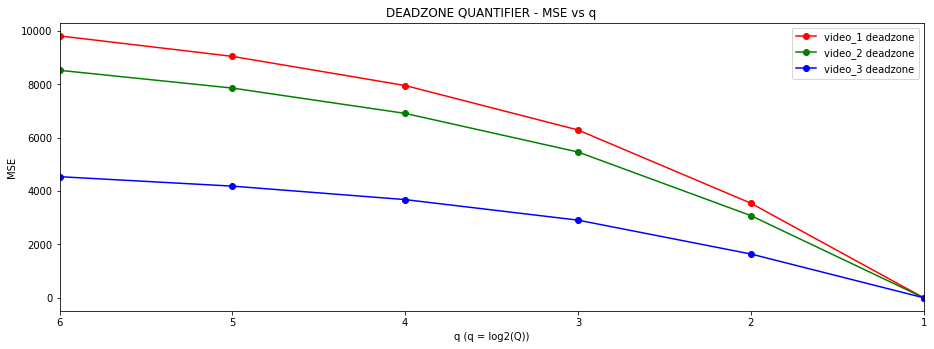

In [33]:
from matplotlib import pyplot as plt
%matplotlib inline

fig=plt.figure()
ax=fig.add_axes([0,0,2,1], yscale='linear')
ax.set_title("DEADZONE QUANTIFIER - MSE vs q")
ax.set_xlabel("q (q = log2(Q))")
ax.set_ylabel("MSE")
ax.set_xticks(x)
ax.set_xlim(np.max(x), np.min(x))
ax.plot(x,mse_dz,'-bo',color='r',label='video_1 deadzone', linestyle='-')
ax.plot(x,mse_dz1,'-bo',color='g',label='video_2 deadzone', linestyle='-')
ax.plot(x,mse_dz2,'-bo',color='b',label='video_3 deadzone', linestyle='-')
ax.legend(loc="upper right")


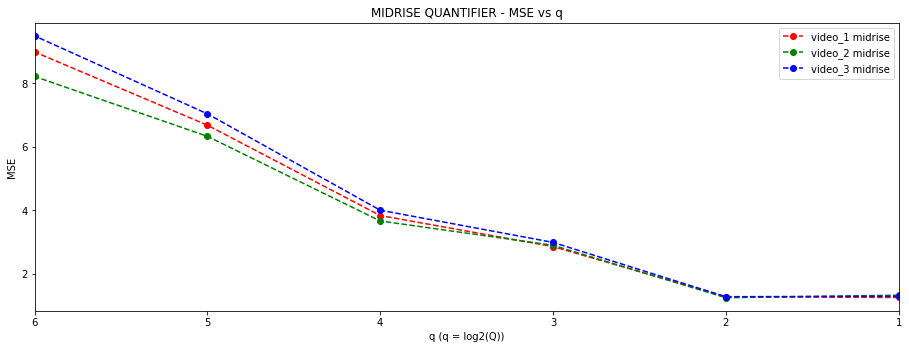

In [34]:
fig1=plt.figure()
ax1=fig1.add_axes([0,0,2,1], yscale='linear')
ax1.set_title("MIDRISE QUANTIFIER - MSE vs q")
ax1.set_xlabel("q (q = log2(Q))")
ax1.set_ylabel("MSE")
ax1.set_xticks(x)
ax1.set_xlim(np.max(x), np.min(x))
ax1.plot(x,mse_mr,'-bo',color='r',label='video_1 midrise', linestyle='--')
ax1.plot(x,mse_mr1,'-bo',color='g',label='video_2 midrise', linestyle='--')
ax1.plot(x,mse_mr2,'-bo',color='b',label='video_3 midrise', linestyle='--')
ax1.legend(loc="upper right")

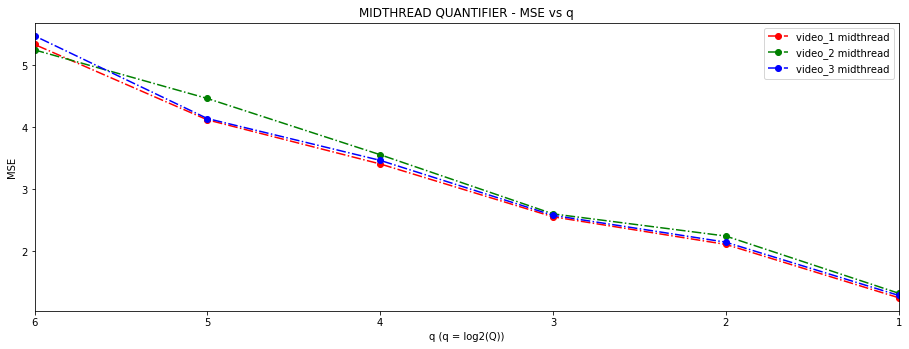

In [35]:
fig2=plt.figure()
ax2=fig2.add_axes([0,0,2,1], yscale='linear')
ax2.set_title("MIDTHREAD QUANTIFIER - MSE vs q")
ax2.set_xlabel("q (q = log2(Q))")
ax2.set_ylabel("MSE")
ax2.set_xticks(x)
ax2.set_xlim(np.max(x), np.min(x))
ax2.plot(x,mse_mt,'-bo',color='r',label='video_1 midthread', linestyle='-.')
ax2.plot(x,mse_mt1,'-bo',color='g',label='video_2 midthread', linestyle='-.')
ax2.plot(x,mse_mt2,'-bo',color='b',label='video_3 midthread', linestyle='-.')
ax2.legend(loc="upper right")

In [ ]:
# from matplotlib import pyplot as plt
# %matplotlib inline

# fig1=plt.figure()
# ax=fig1.add_axes([0,0,2,1], yscale='linear')
# ax.set_title("MSE vs q")
# ax.set_xlabel("q (q = log2(Q))")
# ax.set_ylabel("MSE")
# ax.set_xticks(x)
# ax.set_xlim(np.max(x), np.min(x))

# ax.plot(x,mse_dz,'-bo',color='r',label='video_1 deadzone', linestyle='-')
# ax.plot(x,mse_mr,'-bo',color='g',label='video_1 midrise', linestyle='--')
# ax.plot(x,mse_mt,'-bo',color='b',label='video_1 midthread', linestyle='-.')

# ax.plot(x,mse_dz1,'-bo',color='r',label='video_2 deadzone', linestyle='-')
# ax.plot(x,mse_mr1,'-bo',color='g',label='video_2 midrise', linestyle='--')
# ax.plot(x,mse_mt1,'-bo',color='b',label='video_2 midthread', linestyle='-.')

# ax.plot(x,mse_dz2,'-bo',color='r',label='video_3 deadzone', linestyle='-')
# ax.plot(x,mse_mr2,'-bo',color='g',label='video_3 midrise', linestyle='--')
# ax.plot(x,mse_mt2,'-bo',color='b',label='video_3 midthread', linestyle='-.')
# ax.legend(loc="upper right")